### A quick demonstration of temperature+polarization wiener filtering

In [1]:
import sys
sys.path

['/global/u1/t/toshiyan/Work/Lib/cmblensplus_pkgs/example/curvedsky_utils',
 '/global/homes/t/toshiyan/Work/Lib/tempura_dev',
 '/global/homes/t/toshiyan/Work/Lib/cmblensplus_pkgs/utils',
 '/global/homes/t/toshiyan/Work/Lib/cmblensplus_pkgs',
 '/global/homes/t/toshiyan/Work/Lib/pylib',
 '/opt/nersc/pymon',
 '/global/homes/t/toshiyan/.conda/envs/loc/lib/python37.zip',
 '/global/homes/t/toshiyan/.conda/envs/loc/lib/python3.7',
 '/global/homes/t/toshiyan/.conda/envs/loc/lib/python3.7/lib-dynload',
 '',
 '/global/homes/t/toshiyan/.conda/envs/loc/lib/python3.7/site-packages',
 '/global/u1/t/toshiyan/Work/Lib/actlib/tilec',
 '/global/u1/t/toshiyan/Work/Lib/fgbuster',
 '/global/homes/t/toshiyan/.conda/envs/loc/lib/python3.7/site-packages/IPython/extensions',
 '/global/u1/t/toshiyan/.ipython']

In [2]:
import numpy as np
import healpy as hp
from matplotlib.pyplot import *
# from cmblensplus/wrap/
import cmblensplus.basic as basic
import cmblensplus.curvedsky as cs
# from cmblensplus/utils/
import plottools as pl
import cmb

In [3]:
def generate_alm(Lmax,cl,bl,Nl,ialm):
    alm, nlm = {}, {}
    alm['T'] = ialm['T']*bl[:,None]
    alm['E'] = ialm['E']*bl[:,None]
    alm['B'] = ialm['B']*bl[:,None]
    nlm['T'] = cs.utils.gauss1alm(Lmax,Nl)
    nlm['E'] = cs.utils.gauss1alm(Lmax,Nl*2)
    nlm['B'] = cs.utils.gauss1alm(Lmax,Nl*2)
    return alm, nlm

In [4]:
def alm_to_map(Lmax,nside,alm,nlm):
    omap = {}
    omap['T'] = cs.utils.hp_alm2map(nside,Lmax,Lmax,alm['T']+nlm['T'])
    omap['Q'], omap['U'] = cs.utils.hp_alm2map_spin(nside,Lmax,Lmax,2,alm['E']+nlm['E'],alm['B']+nlm['B'])
    return omap

In [5]:
def map_to_alm(Lmax,nside,omap,wind):
    olm = {}
    olm['T'] = cs.utils.hp_map2alm(nside,Lmax,Lmax,omap['T']*wind)
    olm['E'], olm['B'] = cs.utils.hp_map2alm_spin(nside,Lmax,Lmax,2,omap['Q']*wind,omap['U']*wind)
    return olm

In [6]:
def prep_filtering(wind,sigma,npix,omap):
    # inverse noise covariance
    invn = wind * (sigma*(np.pi/10800.)/Tcmb)**(-2)
    invN = np.reshape(np.array((invn,invn/2.,invn/2.)),(3,1,npix))
    # TQU
    TQU  = np.reshape(np.array((omap['T'],omap['Q'],omap['U'])),(3,1,npix)) # restrict T, Q, U to observed area
    return invN, TQU

In [7]:
# define parameters
Tcmb  = 2.726e6    # CMB temperature
nside0 = 256        # CMB map resolution
lmax0  = 2*nside0     # maximum multipole of alm to be generated
npix0  = 12*nside0**2
nside1 = 512        # CMB map resolution
lmax1  = 2*nside1     # maximum multipole of alm to be generated
npix1  = 12*nside1**2
sigma0 = 5.       # CMB noise in uK-arcmin
sigma1 = 20.
theta0 = 30.
theta1 = 1.
Lmax = max(lmax0,lmax1)
l = np.linspace(0,Lmax,Lmax+1)
lfac = l*(l+1)/2/np.pi

In [8]:
# load cl
cl = cmb.read_camb_cls('../data/lensedcls.dat',ftype='lens',output='array')[:,:Lmax+1]

In [9]:
Nl0 = (sigma0*(np.pi/10800.)/Tcmb)**2 * np.ones(Lmax+1)
Nl1 = (sigma1*(np.pi/10800.)/Tcmb)**2 * np.ones(Lmax+1)

In [10]:
# load survey window
W = hp.fitsfunc.read_map('../data/wmap_temperature_kq85_analysis_mask_r9_9yr_v5.fits',verbose=False)
W0 = hp.ud_grade(W,nside0)
W1 = hp.ud_grade(W,nside1)
M0 = W0/(W0+1e-30) # binary mask
I0 = np.ones(npix0) # fullsky
w20 = np.average(W0**2)
fsky0 = np.average(M0)
M1 = W1/(W1+1e-30) # binary mask
I1 = np.ones(npix1) # fullsky
w21 = np.average(W1**2)
fsky1 = np.average(M1)
print('W2 correction and fsky are',w20,fsky0)
print('W2 correction and fsky are',w21,fsky1)

W2 correction and fsky are 0.74372834 0.75797397
W2 correction and fsky are 0.7480609 0.7480609


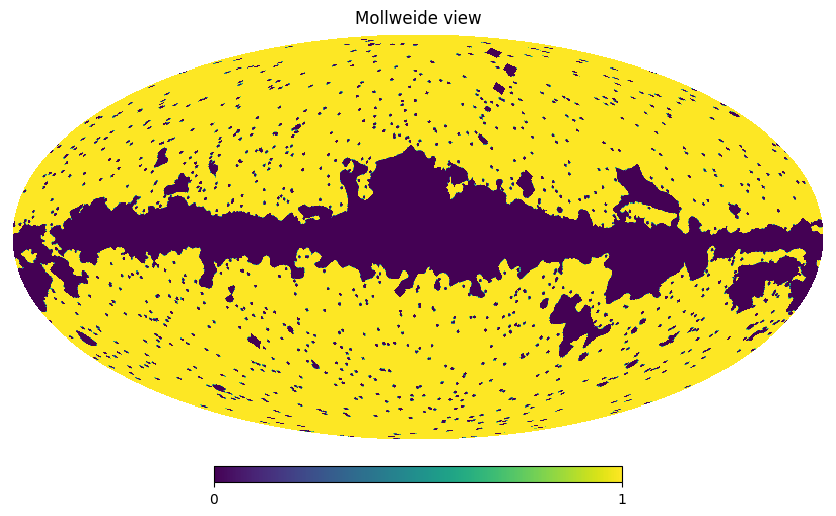

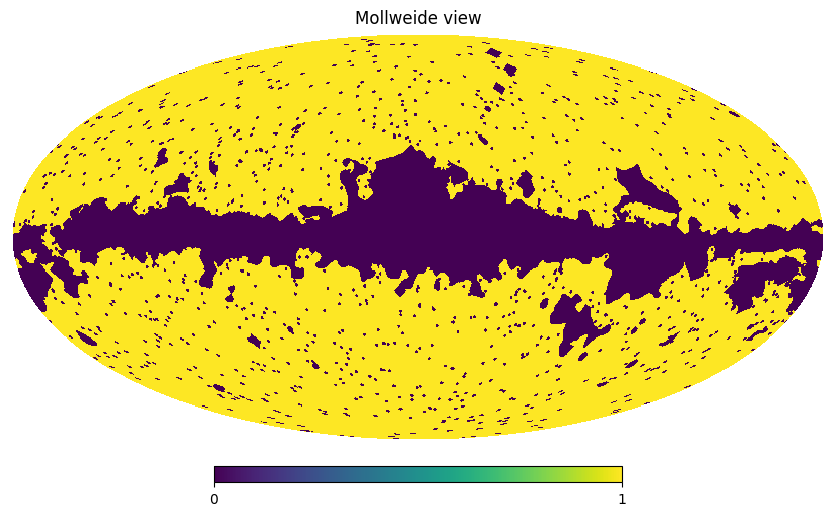

In [11]:
hp.mollview(W0)
hp.mollview(W1)
show()

In [12]:
bl0 = 1./cmb.beam(theta0,Lmax)
Bl0 = np.reshape(bl0,(1,Lmax+1))
bl1 = 1./cmb.beam(theta1,Lmax)
Bl1 = np.reshape(bl1,(1,Lmax+1))

In [ ]:
# Gaussian alms are generated here
ialm = {}
ialm['T'], ialm['E'], ialm['B'] = cs.utils.gaussTEB(cl[0],cl[1],cl[2],cl[3])

In [ ]:

alm0, nlm0 = generate_alm(Lmax,cl,bl0,Nl0,ialm)
alm1, nlm1 = generate_alm(Lmax,cl,bl1,Nl1,ialm)

In [ ]:
# fullsky T/Q/U
omap0 = alm_to_map(Lmax,nside0,alm0,nlm0)
omap1 = alm_to_map(Lmax,nside1,alm1,nlm1)

In [ ]:
# alms from masked T/Q/U
olm0 = map_to_alm(Lmax,nside0,omap0,I0)
olm1 = map_to_alm(Lmax,nside1,omap1,I1)

In [ ]:
# Wiener filtering (test with the trivial case)
invN0, TQU0 = prep_filtering(I0,sigma0,npix0,omap0)
invN1, TQU1 = prep_filtering(I1,sigma1,npix1,omap1)

In [ ]:
wlm = {}
wlm['T'], wlm['E'], wlm['B'] = cs.cninv.cnfilter_freq_nside(
    3, 1, 1, nside0, nside1, Lmax, cl[:3,:], Bl0, Bl1, invN0, invN1, TQU0, TQU1, 
    itns=[100], eps=[1e-5], ro=10, stat='status.txt', inl=np.zeros((3,2,Lmax+1))
)

In [ ]:
for i, (m, y0, y1) in enumerate([('T',1e-11,1e-9),('E',1e-17,1e-9),('B',1e-20,1e-10)]):
    pl.plot_1dstyle(fsize=[7,4],xmin=2,xmax=lmax0,ymin=y0,ymax=y1,ylog=True,ylab=r'$L(L+1)C_L^{'+m+m+'}/2\pi$')
    cl0 = cs.utils.alm2cl(Lmax,olm0[m])/bl0**2
    cl1 = cs.utils.alm2cl(Lmax,olm1[m])/bl1**2
    clw = cs.utils.alm2cl(Lmax,wlm[m])
    plot(l,lfac*cl0,label='signal+noise (sat)')
    plot(l,lfac*cl1,label='signal+noise (lat)')
    plot(l,lfac*clw,label='wiener')
    pfac = 1
    if i>=1:  pfac=2
    Nlc = 1. / ( 1./(Nl0/bl0**2) + 1./(Nl1/bl1**2) )
    plot(l,lfac*cl[i,:]**2/(cl[i,:]+Nlc*pfac),color='k',label='theory')
    legend()
    show()
    clf()